In [1]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [3]:
#Set of parameters

#J
#d
#epsilon
#a_cut
#gamma_du
#gamma_ud
#gamma_el

In [4]:
#### Decaying Rates   
    
    
    
gamma_du=0.4
gamma_ud=0.2
gamma_el=1.6


dis_fac=0.0001

gamma_plus=dis_fac*gamma_du/2   #gamma factor + that appears in the master equation associated to du in natural units of energy.
gamma_minus=dis_fac*gamma_ud/2  #gamma factor - that appears in the master equation associated to ud in natural units of energy.
gamma_z=dis_fac*gamma_el/8      #gamma factor z that appears in the master equation associated to el in natural units of energy.  


In [5]:
def trace(A):
    
    """Returns the trace of a square matrix
    
    Inputs:
    ----------
      -array: array associated to the matrix that we want to determine the trace
    
    Return:
      -complex: return a complex number which is the trace of the matrix of the input""" 
    
    
    return np.trace(A)  #Returns the trace of a square matrix


def matmu(A,B):
    """Perform the matrix multiplication of the matrices A and B of the form A.B
    
    Inputs:
    ----------
      -arrays: two array associated to the matrices A and B respectively
    
    Return:
      -array: array with the result of A.B or raises an error otherwise""" 
    
    return np.matmul(A,B) #Returns the result of the multiplication of matrix A and B in the order A.B

In [6]:
rho_init0=np.array([[1/2,1/2],[1/2,1/2]])

sigma_p= np.array([[0,1],[0,0]])  #Matrix sigma+
sigma_m= np.array([[0,0],[1,0]])  #Matrix sigma-
sigma_z= np.array([[1,0],[0,-1]]) #Matrix sigmaz


##Initial values per operator

sp_init0=trace(matmu(rho_init0,sigma_p))  #initial value for sigma+
sz_init0=trace(matmu(rho_init0,sigma_z))  #initial value for sigma-
sm_init0=trace(matmu(rho_init0,sigma_m))  #initial value for sigmaz

In [7]:
def init_vect(a_cut):
    r0=[]    
    r0.append(sz_init0)  #z initial value
    r0.append(sp_init0)
    r0.append(sz_init0**2)
    

    zp=sz_init0*sp_init0
    pp=sp_init0*sp_init0
    pm=sp_init0*sm_init0

    zp_list=[]
    pp_list=[]
    pm_list=[]

    for j in range(a_cut):
        zp_list.append(zp)
        pp_list.append(pp)
        pm_list.append(pm)

    return r0+zp_list+pp_list+pm_list    

In [8]:
def g_trun(epsilon,a_cut,index_a,partial_terms):
    
    """Compute the function g explained in the main text Infinite_spin_chain.
    
    Input:
    epsilon: exponent in the inverse power law for the potential interaction.
    a_cut: cutoff value of the index a to be considered.
    index_a: first index of the two correlation operators.
    partial_terms: partial terms intended to find a better approximation.
    
    Return: value of g function with the given parameters.    """
    
    terms = [1/abs(n-index_a)**epsilon+1/abs(n+index_a)**epsilon for n in range(a_cut+1,a_cut+partial_terms+1)]
    partial_sum = sum(terms)
    
    if partial_sum<=1e-4:
        return 0
    else:
        return partial_sum

In [481]:
a_cut=30

J=100
N=100

J_aver=J/N    #Javer=J/N
epsilon=3
d=1
partial_terms=100


#J
#d
#epsilon
#a_cut
#### Decaying Rates   
    
    
    
gamma_du=0
gamma_ud=0
gamma_el=0


dis_fac=1

gamma_plus=dis_fac*gamma_du/2   #gamma factor + that appears in the master equation associated to du in natural units of energy.
gamma_minus=dis_fac*gamma_ud/2  #gamma factor - that appears in the master equation associated to ud in natural units of energy.
gamma_z=dis_fac*gamma_el/8      #gamma factor z that appears in the master equation associated to el in natural units of energy.  


def vectorsR(r, t,a_cut=a_cut,J=J_aver,epsilon=epsilon,dist=dist):
    
    
    """Obtains the vector which summarizes the linear and non-linear elements of the differential matrix wrriten of the form
    dr/dt=G(r,t).r, where the matrix G depends of the vector that we want to simulate
    
    Inputs:
    
    Returns:
      -drdt: vector function with the different contributions from linear and non-linear terms that we require to initialize
      odeintz"""
    
    acut_list=list(range(1,a_cut+1))
    
    
    matrix_zero=np.zeros((int(3+3*a_cut),int(3+3*a_cut)),dtype = 'complex_')
    
    drdt = matrix_zero @ r   #sum of the linear and the constant part
    
    gamps=gamma_plus+gamma_minus+4*gamma_z
    gam1=3*(gamma_plus+gamma_minus)+4*gamma_z
    
    drdt[0]=2*(gamma_plus-gamma_minus)-2*(gamma_plus+gamma_minus)*r[0]  #decay
    drdt[1]= 2j*(J/(d**epsilon))*r[0]*r[1]*g_trun(epsilon,a_cut,0,partial_terms)  -gamps*r[1]
    drdt[2]= 4*(gamma_plus-gamma_minus)*r[0]-4*(gamma_plus+gamma_minus)*r[2]  #decay
    
    
    for j in range(0,a_cut):
        
        index1=int(3+a_cut+j)
        index2=int(3+2*a_cut+j)
        
        drdt[1]= drdt[1]+4j*(J/(d**epsilon))*r[3+j]/((j+1)**epsilon)
        
        
        
        drdt[3+j]= drdt[3+j]+2*(gamma_plus-gamma_minus)*r[1]-gam1*r[3+j]  #decay
        
        drdt[3+j]= drdt[3+j]+2j*(J/(d**epsilon))*( r[1]/(j+1)**epsilon +(2*zeta(epsilon)-1/(j+1)**epsilon)*(r[3+j]*r[0]+r[2]*r[1]-2*r[0]**2*r[1]   )  )
        drdt[3+j]= drdt[3+j]+2j*(J/(d**epsilon))*r[0]*( r[0]*r[1]*g_trun(epsilon,a_cut,0,partial_terms)-r[3+j]/(j+1)**epsilon )
        
        

        
        
        drdt[index1]=drdt[index1]-2*gamps*r[index1] #decay
        
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]*(1+1/2**epsilon)*r[3+j]/(j+1)**epsilon
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]**2*r[0]*(g_trun(epsilon,a_cut,0,partial_terms)+g_trun(epsilon,a_cut,j+1,partial_terms))
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*(2*zeta(epsilon)-1/(j+1)**epsilon)*r[0]*(r[index1]-2*r[1]**2)
        

        
        

        
        
        drdt[index2]=drdt[index2]-2*gamps*r[index2] #decay
        
        drdt[index2]=drdt[index2]-4j*(J/(d)**epsilon)*(1/2**epsilon-1)*np.real(np.conjugate(r[1])*r[3+j]/(j+1)**epsilon)
        drdt[index2]=drdt[index2]-4j*(J/(d)**epsilon)*(abs(r[1]))**2*np.real(r[0])*(g_trun(epsilon,a_cut,j+1,partial_terms)-g_trun(epsilon,a_cut,0,partial_terms))
        
        
        for w in range(1,a_cut+1):
            
            drdt[3+j]=drdt[3+j]+4j*(J/(d)**epsilon)*r[0]*r[2+w]/((w)**epsilon)
            
            if w!=j+1:
                drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]*r[2+w]*( 1/abs(w+j+1)**epsilon+1/abs(w-(j+1))**epsilon+2/w**epsilon )
                drdt[index2]=drdt[index2]-4j*(J/(d)**epsilon)*np.real(np.conjugate(r[1])*r[2+w]*(1/abs(w+j+1)**epsilon+1/abs(w-(j+1))**epsilon-2/w**epsilon)   )   
                
        
        
        
        

   
                   
    return drdt



r0=init_vect(a_cut)



In [482]:
init_time=0
final_time=5
steps=200


t = np.linspace(init_time, final_time, steps)

In [483]:
import time

t0=time.time()

z=odeintz(vectorsR, r0, t)#, args=(N,L))


t1=time.time()

print(a_cut,t1-t0)

30 5.859473705291748


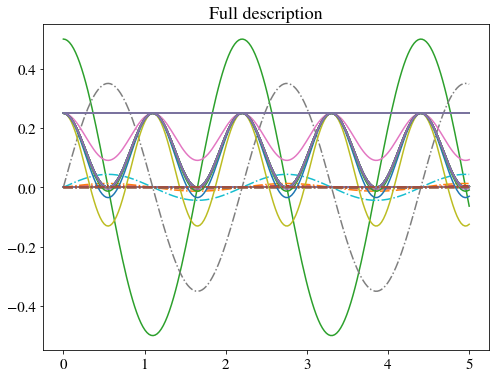

In [484]:
plt.title("Full description")

for j in range(3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]),label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),'-.',label="Im"+str(j))

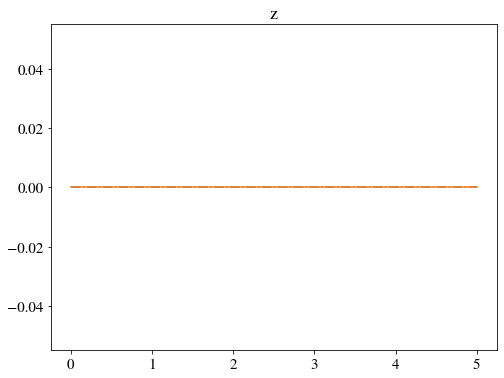

In [485]:
plt.title("z")

plt.plot(t,np.real(z[:,0]),'-.',label="Re"+str(j))
plt.plot(t,np.imag(z[:,0]),label="Im"+str(j))
    #plt.legend()

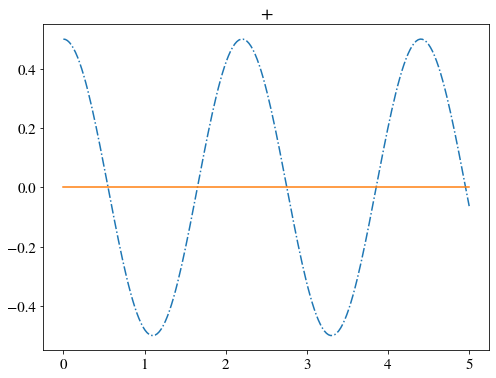

In [486]:
plt.title("+")

plt.plot(t,np.real(z[:,1]),'-.',label="Re"+str(j))
plt.plot(t,np.imag(z[:,1]),label="Im"+str(j))
    #plt.legend()

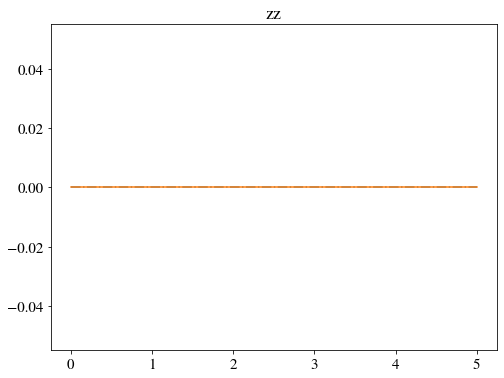

In [487]:
plt.title("zz")

plt.plot(t,np.real(z[:,2]),'-.',label="Re"+str(j))
plt.plot(t,np.imag(z[:,2]),label="Im"+str(j))
    #plt.legend()

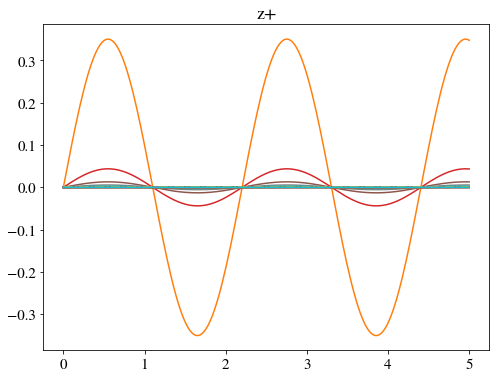

In [488]:
plt.title("z+")
for j in range(3,3+int(a_cut)):
    plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))
    #plt.legend()

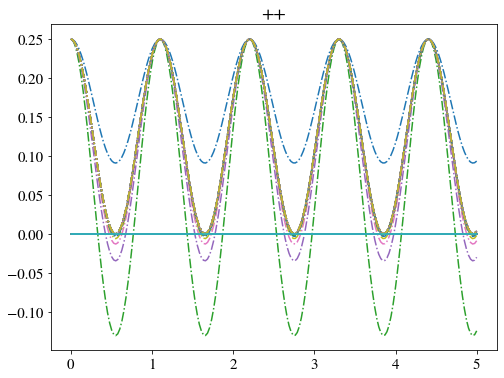

In [489]:
plt.title("++")

for j in range(3+int(a_cut),3+int(2*a_cut)):
    plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))
    #plt.legend()

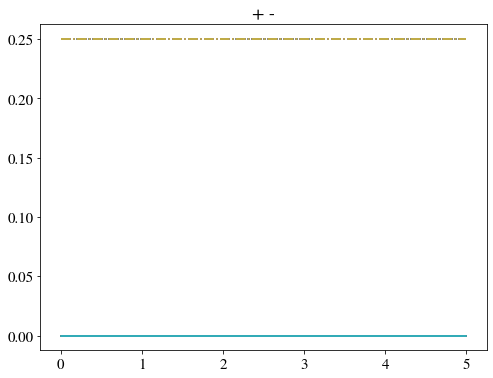

In [490]:
plt.title("+ -")

for j in range(3+int(2*a_cut),3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))

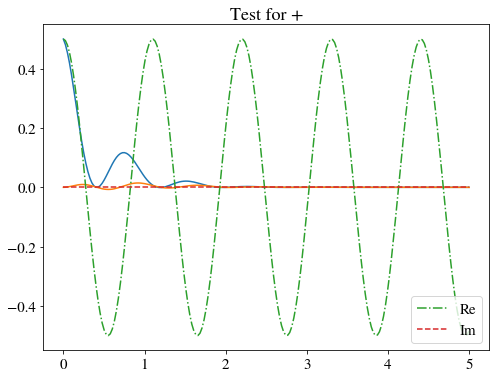

In [366]:
#Test for plus

plt.title("Test for +")

def Phi(t,j):
    func=1
    s=2*1j*gamma+2*J_aver/( (d**epsilon)* (j**epsilon))
    func=func*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5)) 
    return func          
   



def gen_p0(t):
    
    gen_ret=0.5*np.exp(-Tot*t/2)
    
    for j in range(1,N+1):
        gen_ret=gen_ret*(Phi(t,j))**2
    
    return gen_ret
        


plt.plot(t,np.real(gen_p0(t)))
plt.plot(t,np.imag(gen_p0(t)))


plt.plot(t,np.real(z[:,1]),'-.',label="Re")
plt.plot(t,np.imag(z[:,1]),'--',label="Im")

plt.legend()

In [371]:
gamma_r=gamma_ud+gamma_du


gamma=(gamma_ud-gamma_du)/4

Tot=gamma_r+gamma_el
lamda=gamma_r/2

r=gamma_ud*gamma_du

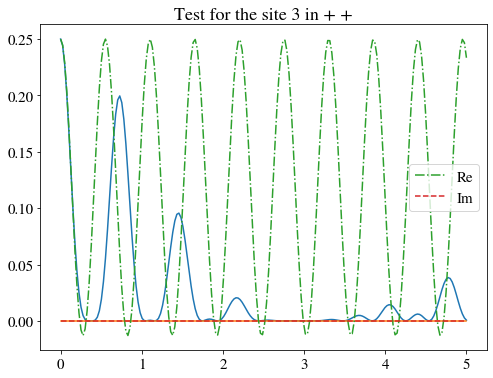

In [369]:
#Test for ++
def gen_pp(t,j):
    
    gen_ret=0.25*np.exp(-2*Tot*t/2)
    s=1

    for w in range(-N,N+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w-j)**epsilon+1/abs(w)**epsilon )
            gen_ret=gen_ret*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5))
            
            
    return gen_ret

#-------------------------------------------


site=3


plt.title("Test for the site "+str(site)+" in + +")

plt.plot(t,np.real(gen_pp(t,site)))
plt.plot(t,np.imag(gen_pp(t,site)))

plt.plot(t,np.real(z[:,3+int((a_cut))+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,3+int((a_cut))+site]),'--',label="Im")

plt.legend()

In [380]:
gamma

0.0

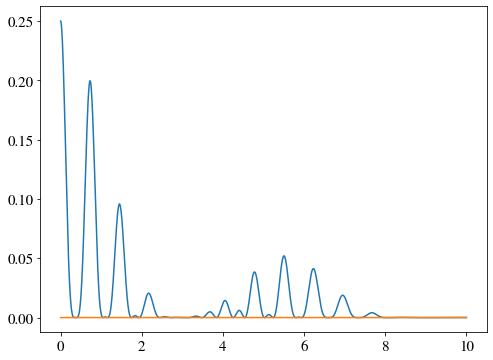

In [389]:
#Test for ++
def gen_pp(t,j):
    
    gen_ret=0.25
    s=1

    for w in range(-N,N+1):
        if w!=j and w!=0:
            s=2*( J_aver/( (d**epsilon)) )*(1/abs(w-j)**epsilon+1/abs(w)**epsilon )
            gen_ret=gen_ret*(np.cos(t*s))
            
            
    return gen_ret

#-------------------------------------------

site=3

t=np.linspace(0,10,2000)


plt.plot(t,np.real(gen_pp(t,site)))
plt.plot(t,np.imag(gen_pp(t,site)))



#We can see a product of cosine terms

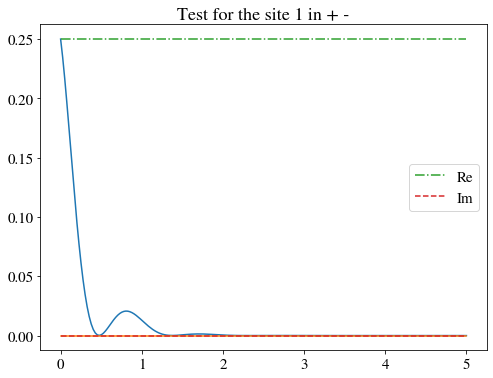

In [367]:
#Test for +-

def gen_pm(t,j):
    
    gen_ret=0.25*np.exp(-2*Tot*t/2)
    s=1

    for w in range(-int(N),int(N)+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w-j)**epsilon-1/abs(w)**epsilon )
            gen_ret=gen_ret*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5))
            
            
    return gen_ret

#------------------------------------


site=1


plt.title("Test for the site "+str(site)+" in + -")

plt.plot(t,np.real(gen_pm(t,site)))

plt.plot(t,np.imag(gen_pm(t,site)))



plt.plot(t,np.real(z[:,3+int(2*(a_cut))+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,3+int(2*(a_cut))+site]),'--',label="Im")


plt.legend()

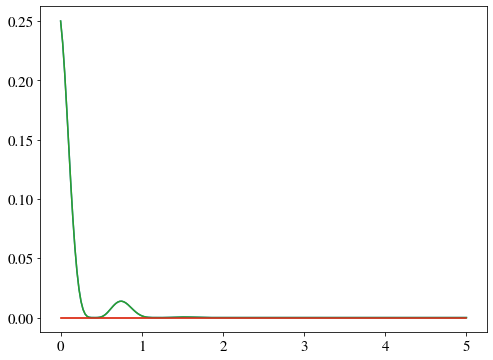

In [355]:
#Test for reflection symmetry


site=-10

plt.plot(t,np.real(gen_pm(t,site)))

plt.plot(t,np.imag(gen_pm(t,site)))

site=10

plt.plot(t,np.real(gen_pm(t,site)))

plt.plot(t,np.imag(gen_pm(t,site)))

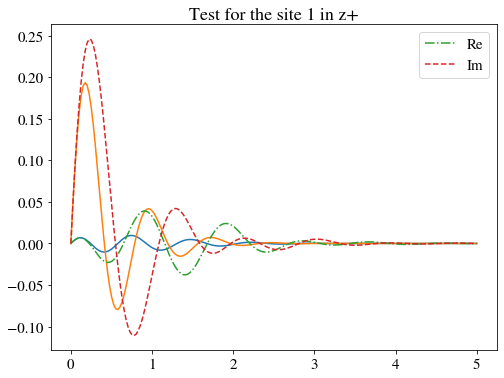

In [351]:
#Test zp

def gen_zp(t,j):
    fun=0.5*np.exp(-Tot*t/2)
    s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(j)**epsilon)
    fun=fun*np.exp(-lamda*t)*(1j*s-2*gamma)*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5)
    
    for w in range(-int(N),int(N)+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w)**epsilon )
            fun=fun*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5))
            
            
    
    
    return fun



site=1


plt.title("Test for the site "+str(site)+" in z+")

plt.plot(t,np.real(gen_zp(t,site)))
plt.plot(t,np.imag(gen_zp(t,site)))



plt.plot(t,np.real(z[:,2+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,2+site]),'--',label="Im")

plt.legend()

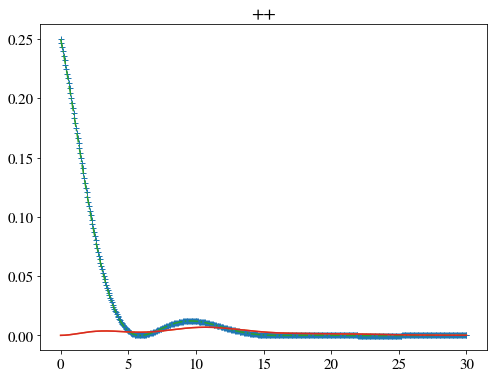

In [532]:
plt.title("++")

#for j in range(3+int(a_cut),3+int(2*a_cut)):

j=3+int(a_cut)

#plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
#plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))

#plt.plot(t,np.real(z[:,j+1]),'-.',label="Re"+str(j))
#plt.plot(t,np.imag(z[:,j+1]),label="Im"+str(j))

plt.plot(t,np.real(z[:,3+int(a_cut)+100]),'+',label="Re"+str(j))
plt.plot(t,np.imag(z[:,3+int(a_cut)]+100),label="Im"+str(j))

plt.plot(t,np.real(z[:,3+int(a_cut)+101]),'-.',label="Re"+str(j))
plt.plot(t,np.imag(z[:,3+int(a_cut)]+101),label="Im"+str(j))

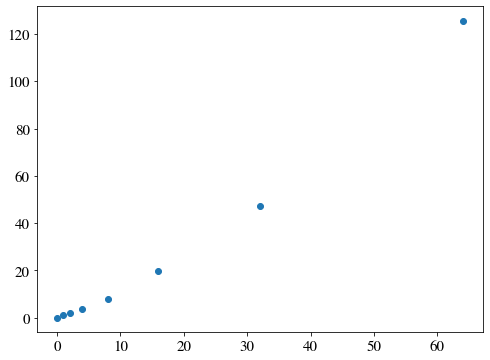

In [47]:
a_cutlist=[0,1,2 ,4 ,8 ,16,32,64,128,256,512,1024]
time_acut=[0.0472,1.073,2.138, 3.855,8.031,19.791,47.399,125.481, 463.041 , 1880.555,5420.327,  15134.7520]


plt.scatter(a_cutlist[:8],time_acut[:8])

plt.yscale("linear")

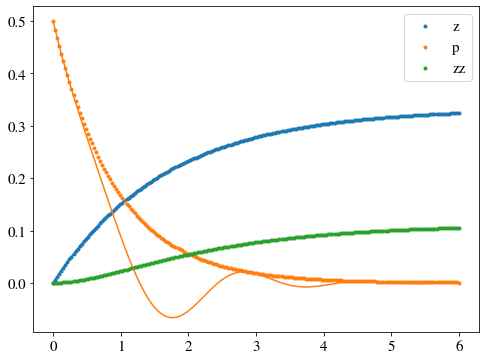

In [1207]:
## Use this cell to check pure decay solely


for j in range(3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]))

    
def f1(t):
    return  (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus)    


def f3(t):
    return ( (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus) )**2
    
def f2(t):
    return  (1/2)*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t)   

def f4(t):
    return  (1/2)*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t) * (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus) 

def f5(t):
    return  f3(t)*f3(t)

def f6(t):
    return  f3(t)*f3(t)

plt.scatter(t,f1(t),marker='.', label="z")   
plt.scatter(t,f2(t),marker='.', label="p") 
plt.scatter(t,f3(t),marker='.', label="zz") 
#plt.scatter(t,f4(t),marker='.', label="zp")
#plt.scatter(t,f5(t),marker='.', label="pp")
#plt.scatter(t,f6(t),marker='+', label="pm")
      

plt.legend()

In [1124]:
g_trun(epsilon,0,0,partial_terms)

2.0346861239298875

In [1158]:
a_cut=0
for j in range(0,a_cut):
    print(j)

for w in range(1,a_cut+1):
    print(a)

In [1160]:
g_trun(epsilon,0,0,partial_terms)/zeta(epsilon)

1.999999999961654

In [1166]:
a_cut=0
partial_terms=100

def zfunc(z, t):
    z0, p0 = z
    
    gamps=gamma_plus+gamma_minus+4*gamma_z
    gam1=3*(gamma_plus+gamma_minus)+4*gamma_z
    dz0dt=2*(gamma_plus-gamma_minus)-2*(gamma_plus+gamma_minus)*z0
    dp0dt=2j*(J/(d**epsilon))*z0*p0*g_trun(epsilon,a_cut,0,partial_terms)  -gamps*p0
        
    return [ dz0dt,dp0dt] 

z0=[0,1/2]

g, infodict = odeintz(zfunc, z0, t, full_output=1)

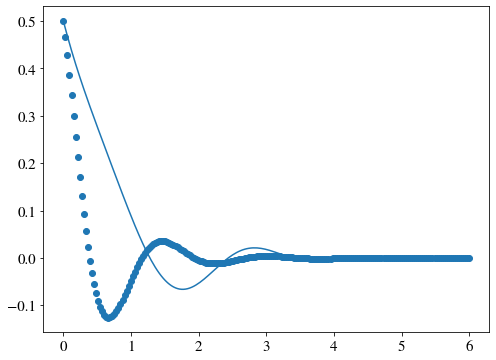

In [1172]:
plt.plot(t,np.real(g[:,1]))


def comp_p0(t):
    v1=0.5*np.exp( (np.exp(-2*(gamma_plus+gamma_minus)*t)-1)/(2*(gamma_plus+gamma_minus)) )
    v1=v1*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t)*np.cos(4*zeta(epsilon)*(J/d**epsilon)*( (gamma_plus-gamma_minus)/(gamma_plus+gamma_minus)  )*t)
    
    return v1

plt.scatter(t,comp_p0(t))

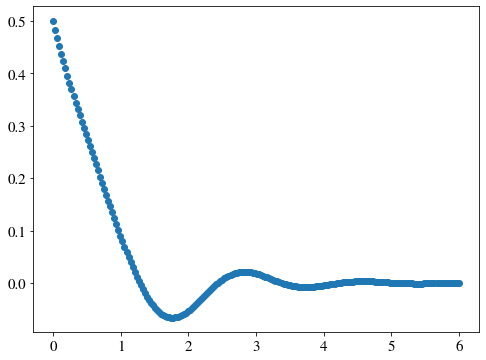

In [1198]:
def comp_p0(t):
    v1=0.5*np.exp(-(gamma_plus+gamma_minus+4*gamma_z) *t )
    gp=gamma_plus+gamma_minus
    gm=gamma_plus-gamma_minus
    
    v1=v1*np.cos(4*zeta(epsilon)*(J/d**epsilon)*( gm/gp  ) *(t+ (np.exp(-2*(gp)*t) -1)/(2*gp) ))
    
    return v1

plt.scatter(t,comp_p0(t))

In [479]:
def zfunc(z, t):
    sx, sy= z
            
    dsxdt=4*zeta(epsilon)*(J_aver/d**epsilon)*sy
    dsydt=-4*zeta(epsilon)*(J_aver/d**epsilon)*sx 
    
    return [dsxdt, dsydt] 

# Set up the inputs and call odeintz to solve the system.
z0=[1,-1]


z = odeintz(zfunc, z0, t)


C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


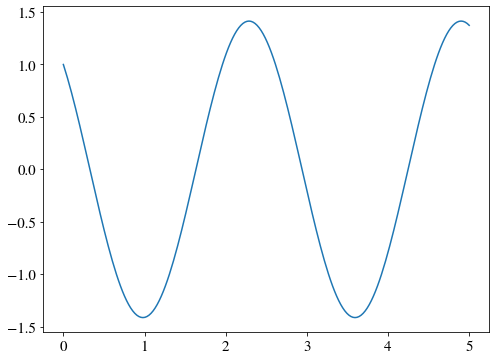

In [480]:
plt.plot(t,z[:,0])

In [569]:
#Initial
J_aver=0.5

def zfunc(z, t):
    sx, sy= z
            
    dsxdt=4*zeta(epsilon)*(J_aver/d**epsilon)*sy
    dsydt=-4*zeta(epsilon)*(J_aver/d**epsilon)*sx 
    
    return [dsxdt, dsydt] 

# Set up the inputs and call odeintz to solve the system.
z0=[(choices([-1,1]))[0],(choices([-1,1]))[0]]

z = odeintz(zfunc, z0, t)


sx_list=z[:,0]
sy_list=z[:,1]
sxsy_list= [z[:,0][i] *z[:,1][i] for i in range(len(z[:,0]))]
sxsx_list= [z[:,0][i] *z[:,0][i] for i in range(len(z[:,0]))]
sysy_list= [z[:,1][i] *z[:,1][i] for i in range(len(z[:,0]))]


In [570]:
def history(n):
    z00=(choices([-1,1]))[0]
    z01=(choices([-1,1]))[0]
    
    z0=[z00,z01]
    z = odeintz(zfunc, z0, t)
    
    sx_list=np.array(z[:,0])
    sy_list=np.array(z[:,1])
    sxsy_list= np.array([z[:,0][i] *z[:,1][i] for i in range(len(z[:,0]))])
    sxsx_list= np.array([z[:,0][i] *z[:,0][i] for i in range(len(z[:,0]))])
    sysy_list= np.array([z[:,1][i] *z[:,1][i] for i in range(len(z[:,0]))])
    
    
    
    
    for j in range(2,n+1):
        
        z0=[(choices([-1,1]))[0],(choices([-1,1]))[0]]
        z = odeintz(zfunc, z0, t)
        
        sx_list = np.add(((j-1)/j)*(sx_list),(1/j)*np.array(z[:,0]))
        sy_list = np.add(((j-1)/j)*(sy_list),(1/j)*np.array(z[:,1]))
        w_xy=     np.array([z[:,0][i] *z[:,1][i] for i in range(len(z[:,0]))])
        w_xx=     np.array([z[:,0][i] *z[:,0][i] for i in range(len(z[:,0]))])
        w_yy=     np.array([z[:,1][i] *z[:,1][i] for i in range(len(z[:,0]))])
        sxsy_list= np.add(((j-1)/j)*(sxsy_list),(1/j)*w_xy)
        sxsx_list= np.add(((j-1)/j)*(sxsx_list),(1/j)*w_xx)
        sysy_list= np.add(((j-1)/j)*(sysy_list),(1/j)*w_yy)
            

    return sx_list,sy_list,sxsy_list,sxsx_list,sysy_list
    

## TWA approximation without noise

In [ ]:
import time

t0=time.time()

n=10000

results=history(n)

t1=time.time()

print(n,t1-t0)

plt.plot(t,np.real(results[0]),label="Sx")
plt.plot(t,np.real(results[1]),label="Sy")
plt.plot(t,np.real(results[2]),label="SxSy")

In [ ]:
plt.plot(t,np.real(results[3]),label="SxSx")
plt.plot(t,np.real(results[4]),label="SySy")

plt.legend()

In [516]:
history(10)[0]

TypeError: 'float' object is not iterable

C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


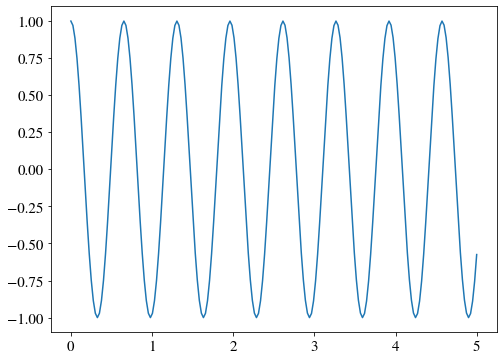

In [500]:
plt.plot(t,res_list)

In [ ]:
def history():
    z0=[(choices([-1,1]))[0],(choices([-1,1]))[0]]
    

In [477]:
from random import choices
count=0
Total=1000000

for j in range(0,Total):
    if (choices([-1,1]))[0]==1:
        count=count+1

print(count/Total)

0.499601


In [491]:
(choices([-1,1]))[0]

-1

In [492]:
(choices([-1,1]))[0]

1